In [1]:
from google.colab import drive
drive.mount('/content/myDrive')

Mounted at /content/myDrive


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import datetime
from scipy.stats import t

In [78]:
path = 'myDrive/MyDrive/Dataset/'

In [79]:
data = pd.read_csv(path+'QVI_data.csv')
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [51]:

data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')

data['MONTH_ID'] = data['DATE'].dt.strftime('%Y%m').astype(int)

print(data[['DATE', 'MONTH_ID']].head())


        DATE  MONTH_ID
0 2018-10-17    201810
1 2018-09-16    201809
2 2019-03-07    201903
3 2019-03-08    201903
4 2018-11-02    201811


In [52]:
# حساب المقاييس الشهرية لكل متجر
measureOverTime = data.groupby(['STORE_NBR', 'MONTH_ID']).agg({
                                                                'TOT_SALES': 'sum',               # total salse
                                                                'LYLTY_CARD_NBR': 'nunique',      # number of customer (unique)
                                                                'TXN_ID': 'count',                # number of transections
                                                                'PROD_QTY': 'sum'                 # total quantity
                                                              }).reset_index()

measureOverTime.rename(columns={'LYLTY_CARD_NBR': 'Customers_ID',
                                'TXN_ID': 'Transections_ID'}, inplace=True)

# number of transactions per customer
measureOverTime['Transections_Per_Customer'] = measureOverTime['Transections_ID'] / measureOverTime['Customers_ID']
# number of chips per customer
measureOverTime['Chips_Per_Customer'] = measureOverTime['PROD_QTY'] / measureOverTime['Customers_ID']
# average price per unit
measureOverTime['AVG_Price_Per_Unit'] = measureOverTime['TOT_SALES'] / measureOverTime['PROD_QTY']


# sort by (store and month)
measureOverTime = measureOverTime.sort_values(by=['STORE_NBR', 'MONTH_ID'])

print(measureOverTime.head(10))


   STORE_NBR  MONTH_ID  TOT_SALES  Customers_ID  Transections_ID  PROD_QTY  \
0          1    201807      206.9            49               52        62   
1          1    201808      176.1            42               43        54   
2          1    201809      278.8            59               62        75   
3          1    201810      188.1            44               45        58   
4          1    201811      192.6            46               47        57   
5          1    201812      189.6            42               47        57   
6          1    201901      154.8            35               36        42   
7          1    201902      225.4            52               55        65   
8          1    201903      192.9            45               49        58   
9          1    201904      192.9            42               43        57   

   Transections_Per_Customer  Chips_Per_Customer  AVG_Price_Per_Unit  
0                   1.061224            1.265306            3.337097  

In [53]:
# Select stores with 12 months of data
store_month_counts = measureOverTime.groupby('STORE_NBR')['MONTH_ID'].nunique()
stores_with_full_obs = store_month_counts[store_month_counts == 12].index

# Filter for pre-trial period (before Feb 2019)
pre_trial_measures = measureOverTime[(measureOverTime['MONTH_ID'] < 201902) & (measureOverTime['STORE_NBR'].isin(stores_with_full_obs))]

print(pre_trial_measures.head(10))


    STORE_NBR  MONTH_ID  TOT_SALES  Customers_ID  Transections_ID  PROD_QTY  \
0           1    201807      206.9            49               52        62   
1           1    201808      176.1            42               43        54   
2           1    201809      278.8            59               62        75   
3           1    201810      188.1            44               45        58   
4           1    201811      192.6            46               47        57   
5           1    201812      189.6            42               47        57   
6           1    201901      154.8            35               36        42   
12          2    201807      150.8            39               41        46   
13          2    201808      193.8            39               43        55   
14          2    201809      154.4            36               37        41   

    Transections_Per_Customer  Chips_Per_Customer  AVG_Price_Per_Unit  
0                    1.061224            1.265306         

In [54]:
# Define function to calculate Pearson correlation between trial and control stores
def calculate_correlation(input_table, metric_col, trial_store):
    trial_data = input_table[input_table['STORE_NBR'] == trial_store][['MONTH_ID', metric_col]].set_index('MONTH_ID')

    results = []
    for control_store in input_table['STORE_NBR'].unique():
        if control_store == trial_store:
            continue
        control_data = input_table[input_table['STORE_NBR'] == control_store][['MONTH_ID', metric_col]].set_index('MONTH_ID')
        merged_data = trial_data.join(control_data, lsuffix='_trial', rsuffix='_control').dropna()
        correlation = merged_data.corr().iloc[0, 1] if not merged_data.empty else 0
        results.append({'Trial_Store': trial_store, 'Control_Store': control_store, 'Correlation': correlation})

    return pd.DataFrame(results)

In [55]:
# Define function to calculate magnitude distance
def calculate_magnitude_distance(input_table, metric_col, trial_store):
    trial_data = input_table[input_table['STORE_NBR'] == trial_store][['MONTH_ID', metric_col]]
    results = []

    for control_store in input_table['STORE_NBR'].unique():
        if control_store == trial_store:
            continue
        control_data = input_table[input_table['STORE_NBR'] == control_store][['MONTH_ID', metric_col]]
        merged_data = trial_data.merge(control_data, on='MONTH_ID', suffixes=('_trial', '_control'))
        merged_data['measure'] = np.abs(merged_data[f'{metric_col}_trial'] - merged_data[f'{metric_col}_control'])
        min_dist, max_dist = merged_data['measure'].min(), merged_data['measure'].max()
        merged_data['magnitude_measure'] = 1 - ((merged_data['measure'] - min_dist) / (max_dist - min_dist)) if max_dist > min_dist else 1
        avg_magnitude = merged_data['magnitude_measure'].mean()

        results.append({'Trial_Store': trial_store, 'Control_Store': control_store, 'Magnitude_Distance': avg_magnitude})

    return pd.DataFrame(results)

In [63]:

def Model(trial_store):
  corr_nSales = calculate_correlation(pre_trial_measures, 'TOT_SALES', trial_store)
  corr_nCustomers = calculate_correlation(pre_trial_measures, 'Customers_ID', trial_store)

  mag_nSales = calculate_magnitude_distance(pre_trial_measures, 'TOT_SALES', trial_store)
  mag_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'Customers_ID', trial_store)

  print("🔹 Top stores based on correlation coefficient in total sales: ")
  print(corr_nSales.sort_values(by='Correlation', ascending=False).head())

  print("\n🔹 Best stores based on customer correlation: ")
  print(corr_nCustomers.sort_values(by='Correlation', ascending=False).head())

  print("\n🔹 Top Stores Based on Standard Distance in Total Sales: ")
  print(mag_nSales.sort_values(by='Magnitude_Distance', ascending=False).head())

  print("\n🔹 Best stores based on standard distance in number of customers: ")
  print(mag_nCustomers.sort_values(by='Magnitude_Distance', ascending=False).head())

  # Specify the weight of the correlation coefficient
  corr_weight = 0.5

  # combined score composed of correlation and magnitude
  score_nSales = pd.merge(corr_nSales, mag_nSales, on=['Trial_Store', 'Control_Store'])
  score_nCustomers = pd.merge(corr_nCustomers, mag_nCustomers, on=['Trial_Store', 'Control_Store'])


  score_nSales['Composite_Score_Sales'] = (corr_weight * score_nSales['Correlation']) + ((1 - corr_weight) * score_nSales['Magnitude_Distance'])
  score_nCustomers['Composite_Score_Customers'] = (corr_weight * score_nCustomers['Correlation']) + ((1 - corr_weight) * score_nCustomers['Magnitude_Distance'])

  print("🔹 Top stores based on composite measure of total sales: ")
  print(score_nSales.sort_values(by='Composite_Score_Sales', ascending=False).head())

  print("\n🔹 Top stores based on composite customer count: ")
  print(score_nCustomers.sort_values(by='Composite_Score_Customers', ascending=False).head())


  # Combine scores across the drivers by first merging our sales scores and customer scores into a single table
  score_Control = pd.merge(score_nSales, score_nCustomers, on=['Trial_Store', 'Control_Store'])

  score_Control['Final_Control_Score'] = (score_Control['Composite_Score_Sales'] * 0.5) + (score_Control['Composite_Score_Customers'] * 0.5)

  # Sort control stores based on final score and choose the best one
  best_control_stores = score_Control.sort_values(by='Final_Control_Score', ascending=False)

  # The store with the highest score is then selected as the control store since it is most similar to the trial store.
  print("🔹 Best Control Stores Based on Final Score: ")
  print(best_control_stores.head())

  selected_control_store = best_control_stores.iloc[0]['Control_Store']
  print('#######################################################################')
  print(f"🔹 The selected control store for the trial store {trial_store} is: {selected_control_store}")
  print('#######################################################################')


  ##########################################

  control_store = selected_control_store  #
  measureOverTimeSales = measureOverTime.copy()

  pre_trial_sales = measureOverTimeSales[measureOverTimeSales['MONTH_ID'] < 201903].copy()
  pre_trial_sales['Store_Type'] = pre_trial_sales['STORE_NBR'].apply(
      lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other Stores')
    )

  # -> Total Sales
  # Calculate average monthly sales for each category
  # Visual checks on trends based on the drivers
  pastSales = pre_trial_sales.groupby(['MONTH_ID', 'Store_Type'])['TOT_SALES'].mean().reset_index()
  pastSales['TransactionMonth'] = pd.to_datetime(pastSales['MONTH_ID'], format='%Y%m')

  plt.figure(figsize=(12, 6))
  sns.lineplot(data=pastSales, x='TransactionMonth', y='TOT_SALES', hue='Store_Type', marker='o')
  plt.xlabel("Month of Operation")
  plt.ylabel("Total Sales")
  plt.title("Total Sales by Month")
  plt.legend(title="Type of Store")
  plt.grid(True)
  plt.show()



  # -> Number of Customers
  #visual checks on customer count trends by comparing the trial store to the control store and other stores.
  pastCustomers = pre_trial_sales.groupby(['MONTH_ID', 'Store_Type'])['Customers_ID'].mean().reset_index()
  pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['MONTH_ID'], format='%Y%m')

  plt.figure(figsize=(12, 6))
  sns.lineplot(data=pastCustomers, x='TransactionMonth', y='Customers_ID', hue='Store_Type', marker='o')
  plt.xlabel("Month of operation")
  plt.ylabel("Number of Customers")
  plt.title("Number of Customers by Month")
  plt.legend(title="Type of Store")
  plt.grid(True)
  plt.show()



  #######################################################

  # For Total Sales

  control_store = selected_control_store

  # Scaling control store sales to match pre-trial trial store sales
  scalingFactorForControlSales = pre_trial_measures[pre_trial_measures['STORE_NBR'] == trial_store]['TOT_SALES'].sum() / \
                  pre_trial_measures[pre_trial_measures['STORE_NBR'] == selected_control_store]['TOT_SALES'].sum()

  print(f"Scaling Factor for Control Sales: {scalingFactorForControlSales}")


  # Apply the scaling factor
  measureOverTimeSales = measureOverTime.copy()
  measureOverTimeSales.loc[measureOverTimeSales['STORE_NBR'] == control_store, 'controlSales'] = measureOverTimeSales.loc[measureOverTimeSales['STORE_NBR'] == control_store, 'TOT_SALES'] * scalingFactorForControlSales
  measureOverTimeSales['Store_type'] = measureOverTimeSales['STORE_NBR'].apply(
      lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
  )


  # Extract sales data for the ( Trial Store ) during the trial period
  # [ Trial period: February 2019 to April 2019 ]
  trial_period = (measureOverTimeSales['MONTH_ID'] >= 201902) & (measureOverTimeSales['MONTH_ID'] <= 201904)

  trial_cust = measureOverTimeSales[(measureOverTimeSales['STORE_NBR'] == trial_store) & trial_period][['MONTH_ID', 'TOT_SALES']]
  control_cust = measureOverTimeSales[(measureOverTimeSales['STORE_NBR'] == control_store) & trial_period][['MONTH_ID', 'controlSales']]

  percentageDiff_Sales = pd.merge(trial_cust, control_cust, on='MONTH_ID', how='inner')
  percentageDiff_Sales['percentageDiff'] = np.abs(percentageDiff_Sales['controlSales'] - percentageDiff_Sales['TOT_SALES']) / percentageDiff_Sales['controlSales'] * 100

  print("\nMerged Customer Data with Percentage Difference during Trial Period:")
  print(percentageDiff_Sales)


  # Calculate the standard deviation of the relative difference in the pre-trial period.
  stdDev = percentageDiff_Sales['percentageDiff'].std()

  # Note that there are 8 months in the pre-trial period
  # hence 8 - 1 = 7 degrees of freedom
  degreesOfFreedom = 7

  print("Standard Deviation of percentage difference (pre-trial):", stdDev)
  print("Degrees of Freedom:", degreesOfFreedom)


  # Calculate the t-values for the trial months
  #### to check whether the hypothesis is statistically significant.
  #### Hint: The test statistic here is (x - u)/standard deviation
  percentageDiff_Sales['tValue'] = (percentageDiff_Sales['percentageDiff']) / stdDev
  percentageDiff_Sales['TransactionMonth'] = pd.to_datetime(percentageDiff_Sales['MONTH_ID'], format='%Y%m')
  print("🔹 Results T-test:")
  print(percentageDiff_Sales[['TransactionMonth', 'percentageDiff', 'tValue']])

  t_critical = t.ppf(0.95, df=degreesOfFreedom)
  print(f"\n🔹 the 95% of the t-distribution: {t_critical}")



  pastSales = measureOverTimeSales[measureOverTimeSales['Store_type'].isin(['Trial', 'Control'])].groupby(['MONTH_ID', 'Store_type'])['TOT_SALES'].mean().reset_index()
  pastSales['TransactionMonth'] = pd.to_datetime(pastSales['MONTH_ID'], format='%Y%m')

  control_sales = pastSales[pastSales['Store_type'] == 'Control'].copy()
  control_sales['Upper'] = control_sales['TOT_SALES'] * (1 + stdDev * 2)
  control_sales['Lower'] = control_sales['TOT_SALES'] * (1 - stdDev * 2)

  trialAssessment_sales = pd.concat([
      pastSales,
      control_sales[['MONTH_ID', 'Upper']].rename(columns={'Upper':'TOT_SALES'}).assign(Store_type='Control 95th % confidence interval'),
      control_sales[['MONTH_ID', 'Lower']].rename(columns={'Lower':'TOT_SALES'}).assign(Store_type='Control 5th % confidence interval')
  ], ignore_index=True)

  trialAssessment_sales['TransactionMonth'] = pd.to_datetime(trialAssessment_sales['MONTH_ID'], format='%Y%m')


  plt.figure(figsize=(12, 6))
  sns.lineplot(data=trialAssessment_sales, x='TransactionMonth', y='TOT_SALES', hue='Store_type', marker='o')
  plt.xlabel("Month of Operation")
  plt.ylabel("Number of Sales")
  plt.title("Number of Sales by Month")
  plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='grey', alpha=0.3, label="Trial Period")
  plt.legend(title="Store Type")
  plt.grid(True)
  plt.show()



  ##############################

  # For Number of Customer
  # calculate Scaling Factor
  pre_trial = measureOverTime[measureOverTime['MONTH_ID'] < 201902]

  trial_customers_sum = pre_trial[pre_trial['STORE_NBR'] == trial_store]['Customers_ID'].sum()
  control_customers_sum = pre_trial[pre_trial['STORE_NBR'] == control_store]['Customers_ID'].sum()

  scalingFactorForControlCust = trial_customers_sum / control_customers_sum
  print("Scaling Factor for Control Customers:", scalingFactorForControlCust)

  # Apply the scaling factor
  measureOverTimeCusts = measureOverTime.copy()
  measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == control_store, 'controlCustomers'] = measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == control_store, 'Customers_ID'] * scalingFactorForControlCust
  measureOverTimeCusts['Store_type'] = measureOverTimeCusts['STORE_NBR'].apply(
      lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
  )

  # Extract modified CUSTOMERS data for the ( Control Store ) during the trial period
  # [ Trial period: February 2019 to April 2019 ]
  trial_period = (measureOverTimeCusts['MONTH_ID'] >= 201902) & (measureOverTimeCusts['MONTH_ID'] <= 201904)

  trial_cust = measureOverTimeCusts[(measureOverTimeCusts['STORE_NBR'] == trial_store) & trial_period][['MONTH_ID', 'Customers_ID']]
  control_cust = measureOverTimeCusts[(measureOverTimeCusts['STORE_NBR'] == control_store) & trial_period][['MONTH_ID', 'controlCustomers']]

  percentageDiff_customers = pd.merge(trial_cust, control_cust, on='MONTH_ID', how='inner')
  percentageDiff_customers['percentageDiff'] = np.abs(percentageDiff_customers['controlCustomers'] - percentageDiff_customers['Customers_ID']) / percentageDiff_customers['controlCustomers'] * 100

  print("\nMerged Customer Data with Percentage Difference during Trial Period:")
  print(percentageDiff_customers)


  # -------------------------------
  trial_cust_pre = pre_trial[pre_trial['STORE_NBR'] == trial_store][['MONTH_ID', 'Customers_ID']]
  control_cust_pre = pre_trial[pre_trial['STORE_NBR'] == control_store][['MONTH_ID', 'Customers_ID']]

  control_cust_pre = control_cust_pre.copy()
  control_cust_pre['controlCustomers'] = control_cust_pre['Customers_ID'] * scalingFactorForControlCust

  merged_customers_pre = pd.merge(trial_cust_pre, control_cust_pre[['MONTH_ID', 'controlCustomers']], on='MONTH_ID', how='inner')
  merged_customers_pre['percentageDiff'] = np.abs(merged_customers_pre['controlCustomers'] - merged_customers_pre['Customers_ID']) / merged_customers_pre['controlCustomers'] * 100

  stdDev_customers = merged_customers_pre['percentageDiff'].std()
  degreesOfFreedom = 7

  print("\nStandard Deviation of percentage differences (pre-trial) for Customers:", stdDev_customers)
  print("Degrees of Freedom:", degreesOfFreedom)

  # Calculate the average number of customers per month for each category (Trial and Control) during the pre-trial period
  pastCustomers = measureOverTimeCusts[measureOverTimeCusts['Store_type'].isin(['Trial', 'Control'])].groupby(['MONTH_ID', 'Store_type'])['Customers_ID'].mean().reset_index()
  pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['MONTH_ID'], format='%Y%m')

  control_customers = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
  control_customers['Upper'] = control_customers['Customers_ID'] * (1 + stdDev_customers * 2)
  control_customers['Lower'] = control_customers['Customers_ID'] * (1 - stdDev_customers * 2)

  trialAssessment_customers = pd.concat([
      pastCustomers,
      control_customers[['MONTH_ID', 'Upper']].rename(columns={'Upper':'Customers_ID'}).assign(Store_type='Control 95th % confidence interval'),
      control_customers[['MONTH_ID', 'Lower']].rename(columns={'Lower':'Customers_ID'}).assign(Store_type='Control 5th % confidence interval')
  ], ignore_index=True)

  trialAssessment_customers['TransactionMonth'] = pd.to_datetime(trialAssessment_customers['MONTH_ID'], format='%Y%m')

  plt.figure(figsize=(12, 6))
  sns.lineplot(data=trialAssessment_customers, x='TransactionMonth', y='Customers_ID', hue='Store_type', marker='o')
  plt.xlabel("Month of Operation")
  plt.ylabel("Number of Customers")
  plt.title("Number of Customers by Month")
  plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='grey', alpha=0.3, label="Trial Period")
  plt.legend(title="Store Type")
  plt.grid(True)
  plt.show()


🔹 Top stores based on correlation coefficient in total sales: 
     Trial_Store  Control_Store  Correlation
67            77             71     0.914106
220           77            233     0.903774
110           77            119     0.867664
15            77             17     0.842668
2             77              3     0.806644

🔹 Best stores based on customer correlation: 
     Trial_Store  Control_Store  Correlation
220           77            233     0.990358
110           77            119     0.983267
240           77            254     0.916208
105           77            113     0.901348
78            77             84     0.858571

🔹 Top Stores Based on Standard Distance in Total Sales: 
     Trial_Store  Control_Store  Magnitude_Distance
16            77             18            0.733070
107           77            115            0.727536
65            77             69            0.720729
40            77             43            0.715421
109           77            118 

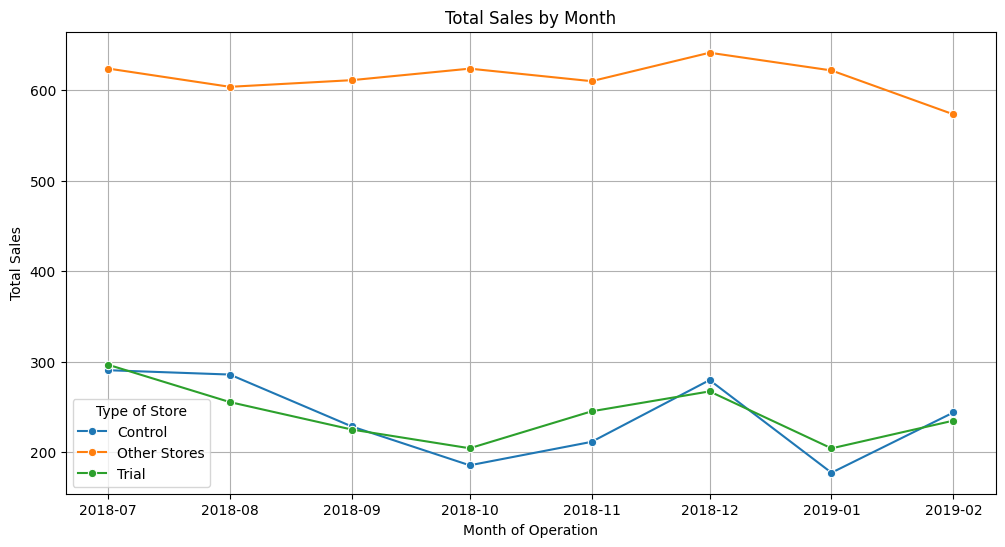

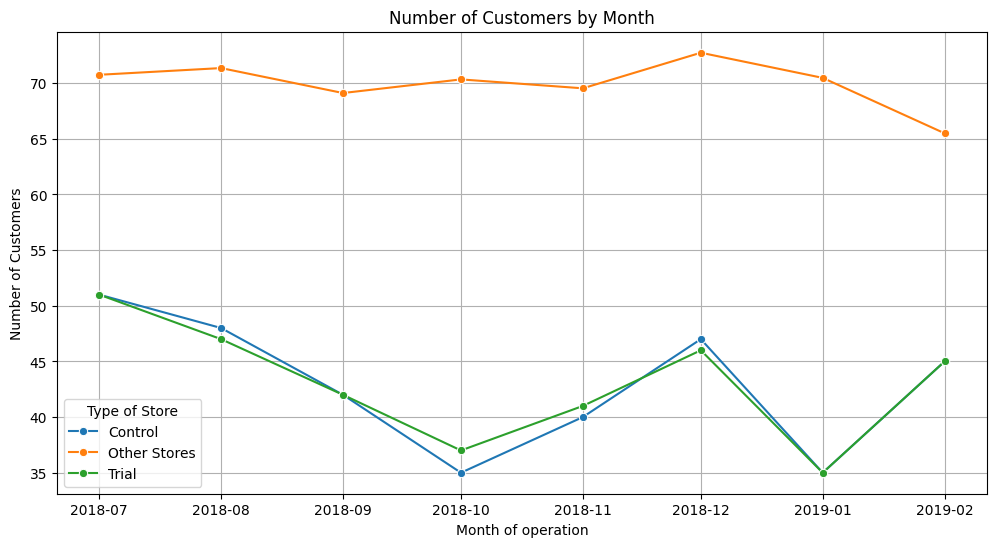

Scaling Factor for Control Sales: 1.023617303289553

Merged Customer Data with Percentage Difference during Trial Period:
   MONTH_ID  TOT_SALES  controlSales  percentageDiff
0    201902      235.0    249.762622        5.910661
1    201903      278.5    203.802205       36.652103
2    201904      263.5    162.345704       62.307960
Standard Deviation of percentage difference (pre-trial): 28.236839130449365
Degrees of Freedom: 7
🔹 Results T-test:
  TransactionMonth  percentageDiff    tValue
0       2019-02-01        5.910661  0.209324
1       2019-03-01       36.652103  1.298024
2       2019-04-01       62.307960  2.206619

🔹 the 95% of the t-distribution: 1.894578605061305


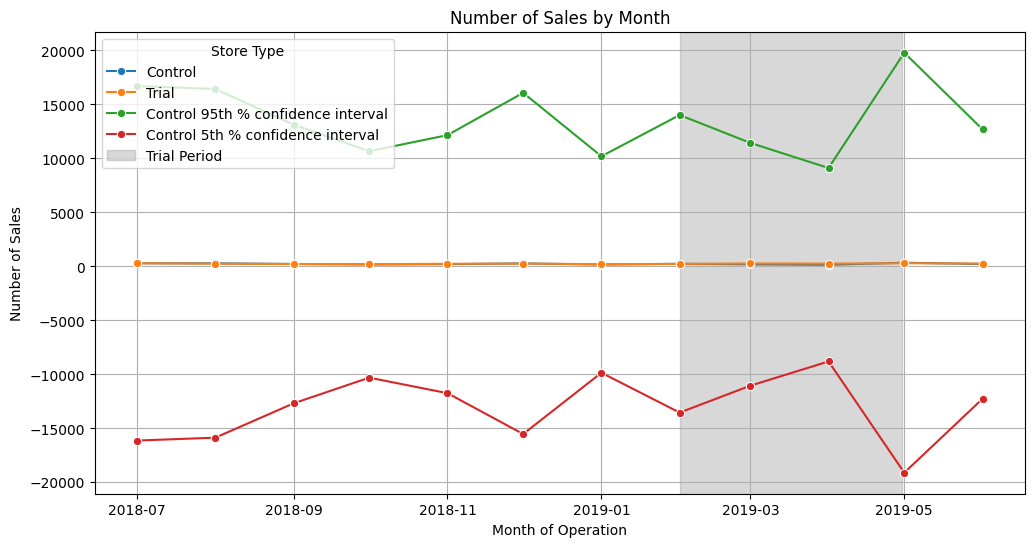

Scaling Factor for Control Customers: 1.0033557046979866

Merged Customer Data with Percentage Difference during Trial Period:
   MONTH_ID  Customers_ID  controlCustomers  percentageDiff
0    201902            45         45.151007        0.334448
1    201903            50         40.134228       24.581940
2    201904            47         30.100671       56.142698

Standard Deviation of percentage differences (pre-trial) for Customers: 1.8240748558243944
Degrees of Freedom: 7


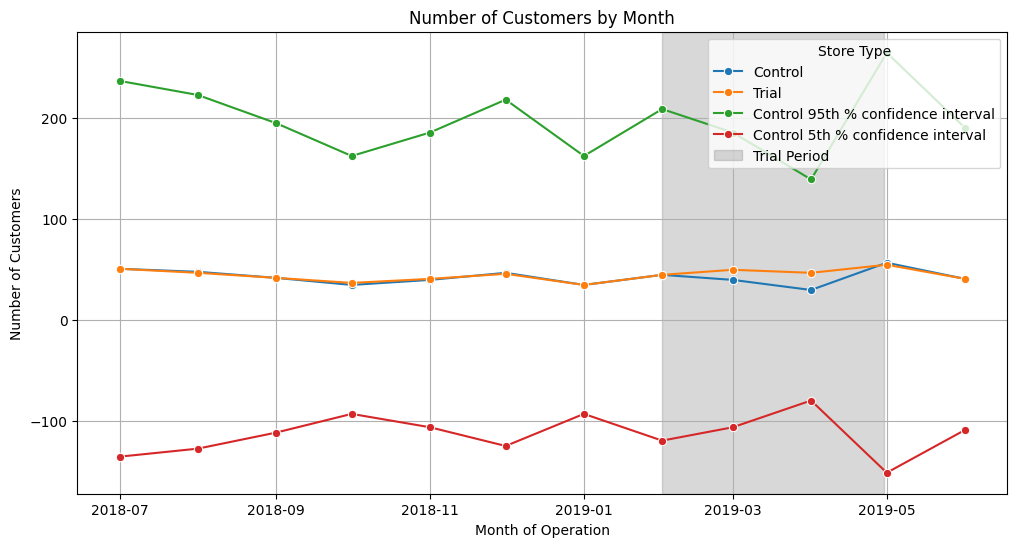

In [64]:
# @title 1- Select Trial Store (77)
Model(77)

🔹 Top stores based on correlation coefficient in total sales: 
     Trial_Store  Control_Store  Correlation
146           86            155     0.877882
123           86            132     0.846517
227           86            240     0.825066
209           86            222     0.795075
101           86            109     0.788300

🔹 Best stores based on customer correlation: 
     Trial_Store  Control_Store  Correlation
146           86            155     0.942876
106           86            114     0.855339
246           86            260     0.846502
167           86            176     0.796380
101           86            109     0.770778

🔹 Top Stores Based on Standard Distance in Total Sales: 
     Trial_Store  Control_Store  Magnitude_Distance
206           86            219            0.791515
86            86             94            0.772267
228           86            241            0.758264
98            86            106            0.739031
146           86            155 

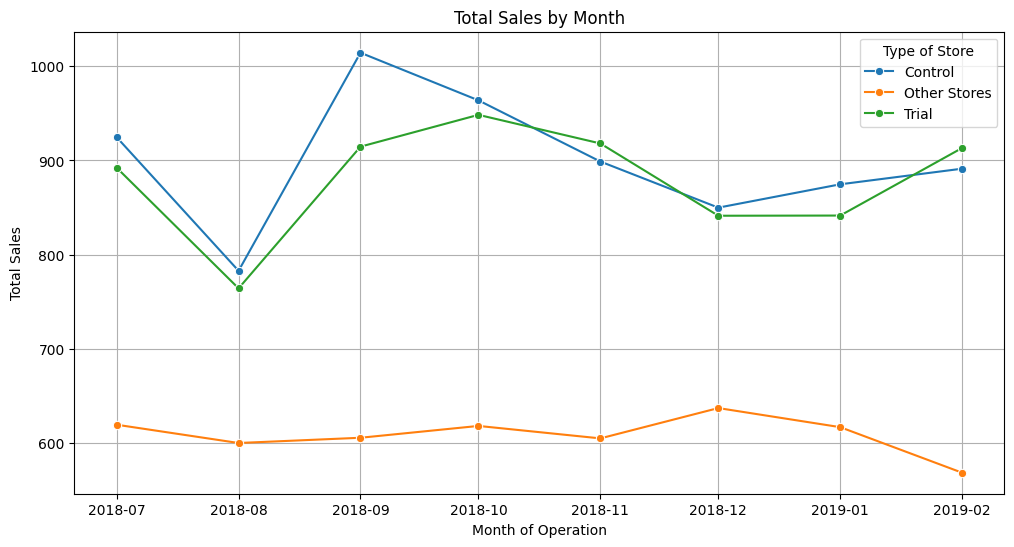

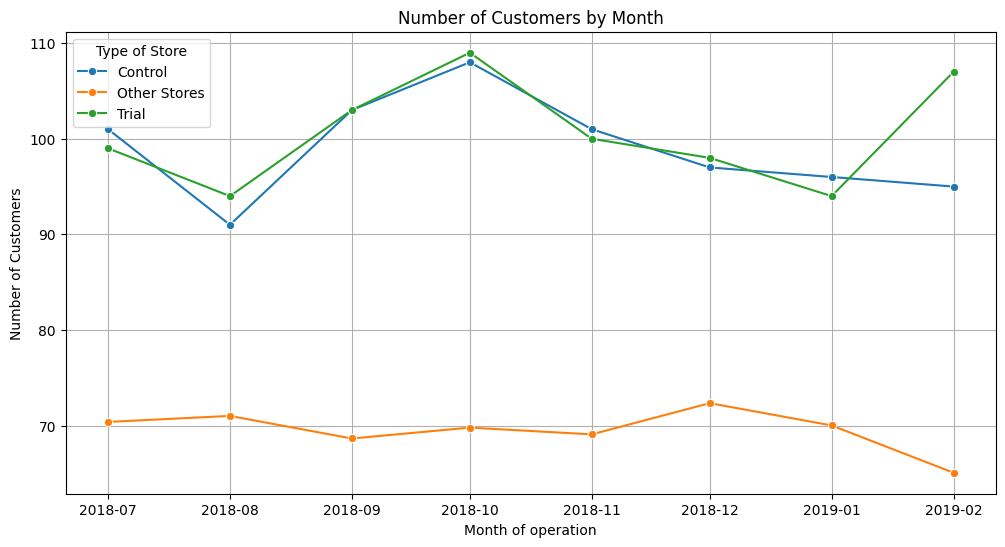

Scaling Factor for Control Sales: 0.9700651481287743

Merged Customer Data with Percentage Difference during Trial Period:
   MONTH_ID  TOT_SALES  controlSales  percentageDiff
0    201902      913.2    864.522060        5.630619
1    201903     1026.8    780.320405       31.586973
2    201904      848.2    819.317024        3.525250
Standard Deviation of percentage difference (pre-trial): 15.629167059831852
Degrees of Freedom: 7
🔹 Results T-test:
  TransactionMonth  percentageDiff    tValue
0       2019-02-01        5.630619  0.360264
1       2019-03-01       31.586973  2.021027
2       2019-04-01        3.525250  0.225556

🔹 the 95% of the t-distribution: 1.894578605061305


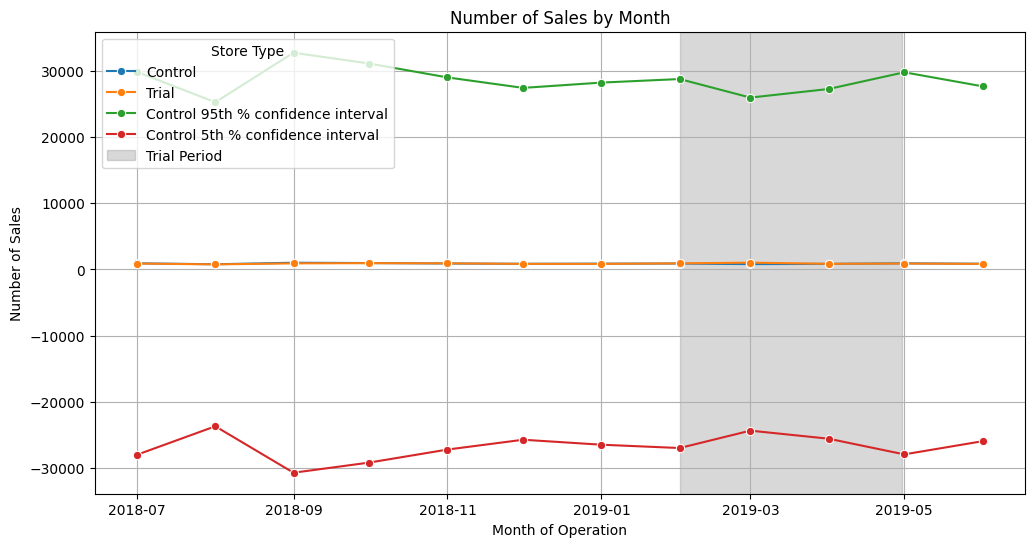

Scaling Factor for Control Customers: 1.0

Merged Customer Data with Percentage Difference during Trial Period:
   MONTH_ID  Customers_ID  controlCustomers  percentageDiff
0    201902           107              95.0       12.631579
1    201903           115              94.0       22.340426
2    201904           105              99.0        6.060606

Standard Deviation of percentage differences (pre-trial) for Customers: 1.0687444701395237
Degrees of Freedom: 7


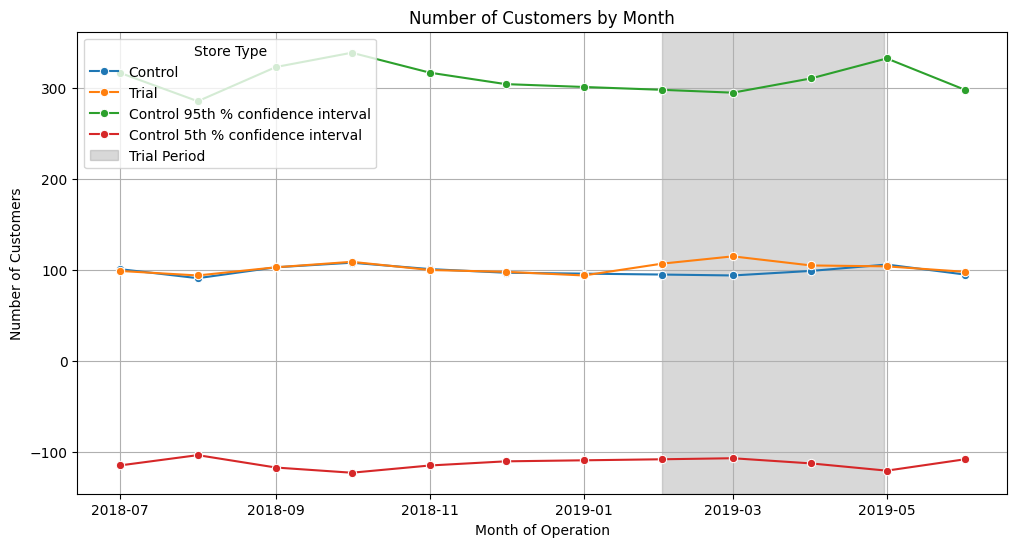

In [65]:
# @title 2- Select Trial Store (86)
Model(86)

🔹 Top stores based on correlation coefficient in total sales: 
     Trial_Store  Control_Store  Correlation
150           88            159     0.903186
194           88            204     0.885774
125           88            134     0.864293
0             88              1     0.813636
239           88            253     0.811838

🔹 Best stores based on customer correlation: 
     Trial_Store  Control_Store  Correlation
224           88            237     0.947326
12            88             14     0.942976
169           88            178     0.939466
32            88             35     0.899594
105           88            113     0.862632

🔹 Top Stores Based on Standard Distance in Total Sales: 
     Trial_Store  Control_Store  Magnitude_Distance
208           88            221            0.741386
37            88             40            0.732887
206           88            219            0.725323
203           88            215            0.690509
238           88            251 

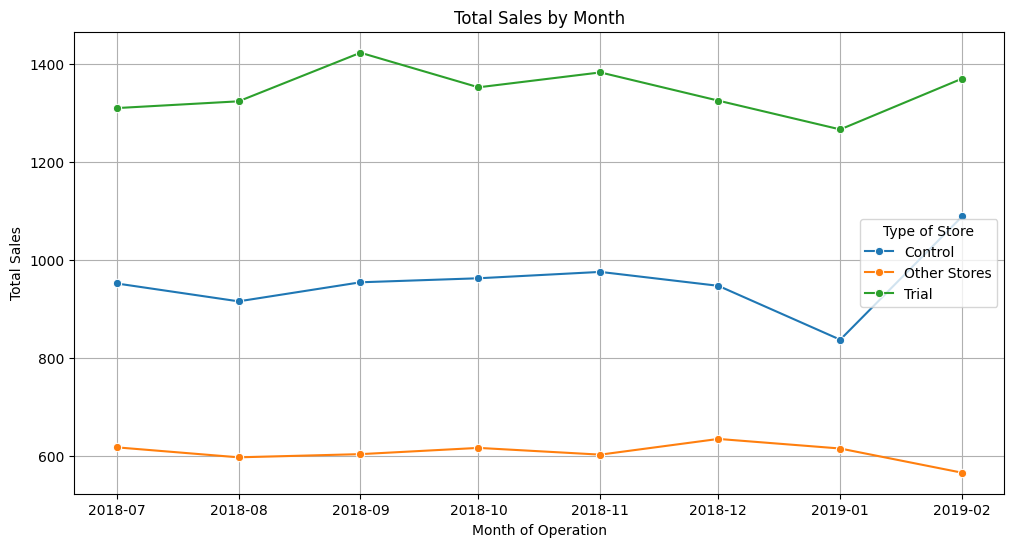

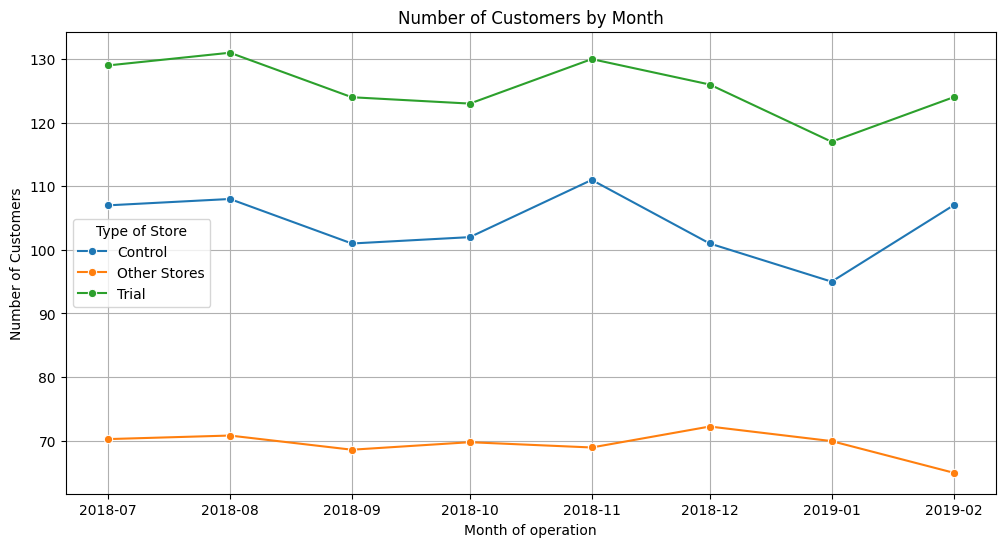

Scaling Factor for Control Sales: 1.4338146535258616

Merged Customer Data with Percentage Difference during Trial Period:
   MONTH_ID  TOT_SALES  controlSales  percentageDiff
0    201902     1370.2   1561.137395       12.230659
1    201903     1477.2   1432.094076        3.149648
2    201904     1439.4   1519.556770        5.275010
Standard Deviation of percentage difference (pre-trial): 4.749789173167976
Degrees of Freedom: 7
🔹 Results T-test:
  TransactionMonth  percentageDiff    tValue
0       2019-02-01       12.230659  2.574990
1       2019-03-01        3.149648  0.663113
2       2019-04-01        5.275010  1.110578

🔹 the 95% of the t-distribution: 1.894578605061305


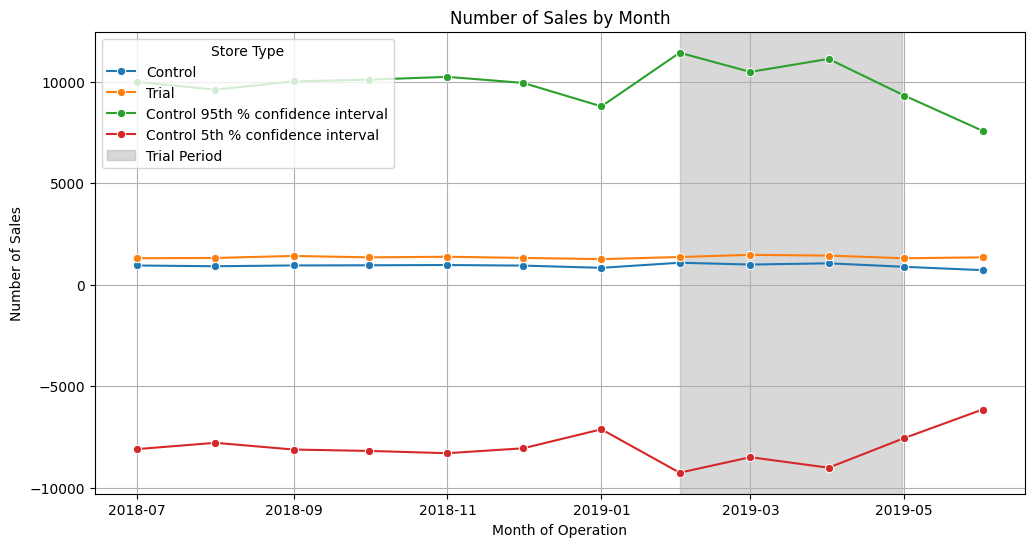

Scaling Factor for Control Customers: 1.2137931034482758

Merged Customer Data with Percentage Difference during Trial Period:
   MONTH_ID  Customers_ID  controlCustomers  percentageDiff
0    201902           124        129.875862        4.524214
1    201903           134        138.372414        3.159888
2    201904           128        142.013793        9.867910

Standard Deviation of percentage differences (pre-trial) for Customers: 1.2417826272588404
Degrees of Freedom: 7


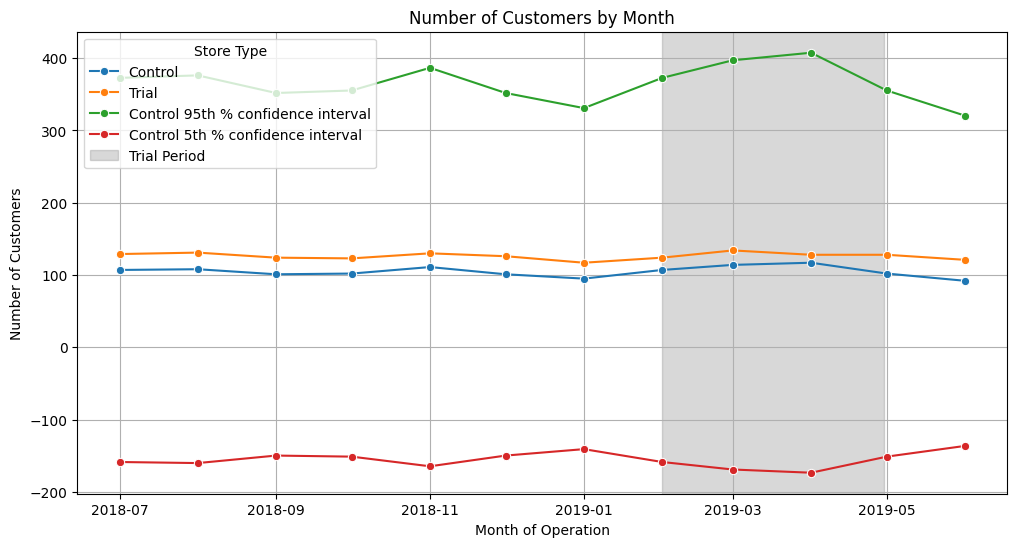

In [66]:
## @title 3- Select Trial Store (88)
Model(88)